In [271]:
import os, re
import pandas
import matplotlib.pyplot as plt

from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, models, transforms
import torch
import time
import os
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ConvertImageDtype, Normalize
import torchvision.transforms.functional as F
from tempfile import TemporaryDirectory

root_dir        = '/home/paula/Data/paula' # directorio raíz
dataset_name     = 'MURA-v1.1' 
study_type       = 'XR_WRIST'
train = False
annotation_files   = {'train':'train_labeled.csv', 'test':'valid_labeled.csv'}
data_split_folders = {'train': 'train', 'test':'valid'}

In [272]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [273]:
# Defnición de clase MuraDataset para poner en un módulo que se importará
# El módulo es un fichero .py (por ejemplo muradataset.py) accesible (para simplificar, en misma carpeta)

import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode

class MuraDataset(Dataset):
    # La clase hereda de torch,utils.data.Dataset
    # Los datasets en pytorch deben tener Dataset como ancestro

    # Variables de clase, comunes para todos los objetos de la misma
    dataset_name       = 'MURA-v1.1' 
    annotation_files   = {'train':'train_labeled.csv', 'test':'valid_labeled.csv'}
    data_split_folders = {'train': 'train', 'test':'valid'}
    labels_map         = {0: 'negativo', 1:'positivo'}

    # Método de inicialización de los objetos de la clase. Sobreescribe al de Dataset
    def __init__(self, root_dir, study_type='XR_WRIST', train=True, rgb=True, transform=None, target_transform=None):

        self.root_dir = root_dir
        self.train = train
        self.rgb = rgb
        #self.img_dir = os.path.normpath(
        #    (os.path.join(root_dir, dataset_name, data_split_folders['train'], study_type) if train 
        #                else os.path.join(root_dir, dataset_name, data_split_folders['test'], study_type)))

        self.annotations_file =  os.path.normpath(
            (os.path.join(root_dir, dataset_name, annotation_files['train']) if train else 
                                  os.path.join(root_dir, dataset_name, annotation_files['test'])))
        all_img_labels  = pd.read_csv(self.annotations_file) # Se carga el fichero con todos los estudios
        # Se selecciona el tipo de estudio. EL data frame tiene la ruta a cada imagen y su etiqueta
        self.img_labels = all_img_labels.iloc[(all_img_labels['Path'].str.contains(study_type)).to_numpy()].copy()
        
        
        self.transform = transform
        self.target_transform = target_transform
    
    # Método de longitud del dataset. Sobreescribe al de Dataset
    def __len__(self):
        return len(self.img_labels)

    # Método para obtener una única imagen y su etiqueta correspondiente 
    def __getitem__(self, idx):
        # Ruta al fichero con la imagen
        img_path = os.path.join(self.root_dir, self.img_labels.iloc[idx, 0])
        
        im_mode= ImageReadMode.RGB if self.rgb else ImageReadMode.GRAY 
        image = read_image(img_path, mode=im_mode)
        
        # Se obtiene la etiqueta correspondiente
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [274]:
# Comprobamos que pueden leerse las imágenes en gris y en RGB
# en Pytorch las bandas son C (color),H (altura),W (anchura)
# Mientras que normalmente es H, W, C. Hay que tenerlo en cuenta para visualizar  
img_data = MuraDataset(root_dir, rgb=False)
sample_idx = torch.randint(len(img_data), size=(1,)).item()
img, label = img_data[sample_idx]

print(img.shape, '\t', img.dtype)
print('Pixel arbitrario:\t', img[:,10,150])

torch.Size([1, 512, 324]) 	 torch.uint8
Pixel arbitrario:	 tensor([40], dtype=torch.uint8)


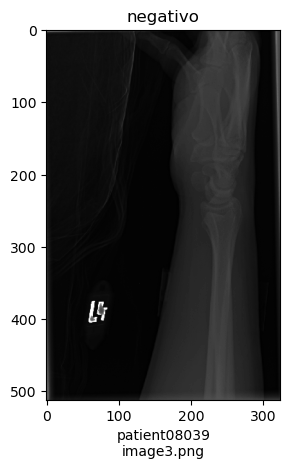

In [275]:
# Convertimos imagen de tensores a imagen PIL para representarla
plt.imshow(F.to_pil_image(img), cmap='gray')
patient = re.search(r'\bpatient\d+\b', img_data.img_labels.iloc[sample_idx,0]).group()

plt.xlabel(patient+'\n'+ os.path.basename(img_data.img_labels.iloc[sample_idx,0]))
plt.title(img_data.labels_map[label])
plt.show()

In [276]:
# Explícitamente pedimos que se lea como RGB, pues estaba puesto como gris
img_data.rgb=True
img, label = img_data[sample_idx]

print(img.shape, '\t', img.dtype)
print('Pixel arbitrario:\t', img[:,10,150])

torch.Size([3, 512, 324]) 	 torch.uint8
Pixel arbitrario:	 tensor([40, 40, 40], dtype=torch.uint8)


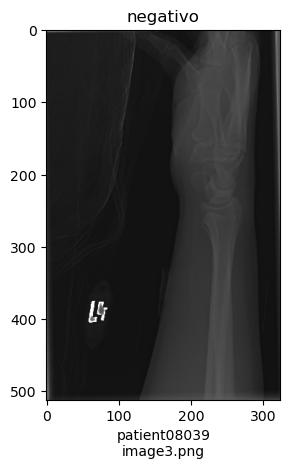

In [277]:
# Convertimos imagen de tensores a imagen PIL para representarla
plt.imshow(F.to_pil_image(img), cmap='gray')

patient = re.search(r'\bpatient\d+\b', img_data.img_labels.iloc[sample_idx,0]).group()
plt.xlabel(patient+'\n'+ os.path.basename(img_data.img_labels.iloc[sample_idx,0]))
plt.title(img_data.labels_map[label])
plt.show()

In [278]:
# La clase Dataset permite transformar las imágenes, para
# adecuarlas a la cadena posterior de procesado
# En el caso de DenseNet, podemos tomar de referencia
# https://pytorch.org/hub/pytorch_vision_densenet/
# La red espera imágenes RGB 

transform = Compose([
    # Se ajustan las dimensiones de la imagen al tamaño que espera la red neuronal
    Resize(size=(224,224)),
    # Las imágenes se convierten a punto flotante (eran enteras) 
     ConvertImageDtype(torch.float),
    # Se normalizan los valores. En el caso de imágenes grises con
    # tres canales, resultarán canales con valores diferentes
    # y se verán en color. Los píxeles pueden tener valores negativos
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ])

In [279]:
training_data = MuraDataset(
    root_dir=root_dir,
    study_type='XR_WRIST',
    train=True,
    rgb=True,
    transform=transform
    )

print('Tamaño del dataset de entrenamiento:\t', len(training_data))

test_data = MuraDataset(
    root_dir=root_dir,
    study_type='XR_WRIST',
    train=False,
    rgb=True,
    transform=transform
    )

print('Tamaño del dataset de test:\t', len(test_data))

Tamaño del dataset de entrenamiento:	 9752
Tamaño del dataset de test:	 659


torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-0.6452, -0.5301, -0.3055])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-1.1932, -1.0903, -0.8633])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-1.4672, -1.3704, -1.1421])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-0.2342, -0.1099,  0.1128])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-1.1760, -1.0728, -0.8458])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-1.5870, -1.4930, -1.2641])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-1.1760, -1.0728, -0.8458])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-1.1418, -1.0378, -0.8110])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-1.1932, -1.0903, -0.8633])


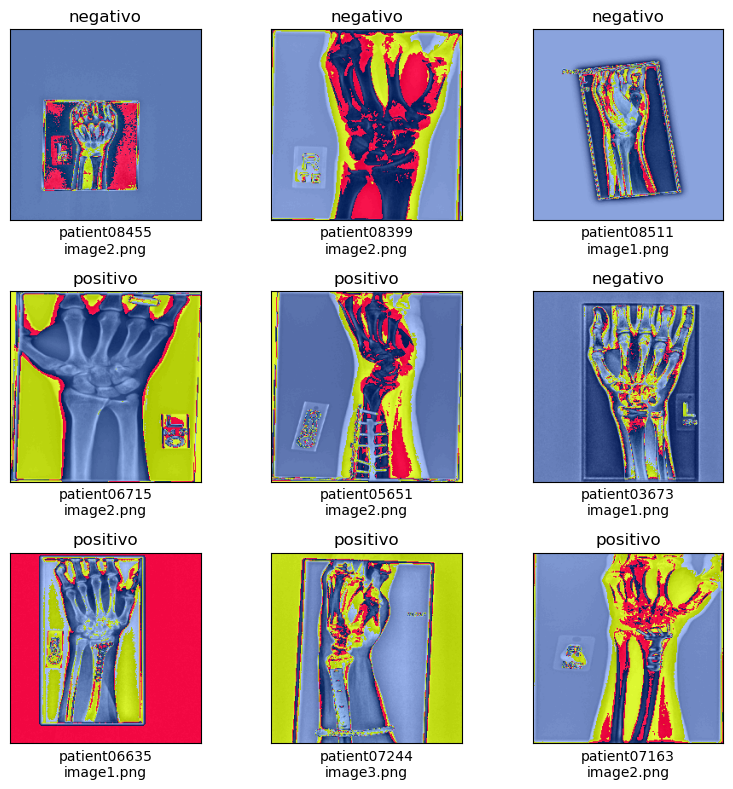

In [280]:
nrows, ncols = 3,3

fig, axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=(8,8))
for r in range(nrows):
    for c in range(ncols):
        sample_idx = torch.randint(len(training_data), size=(1,)).item()

        img, label = training_data[sample_idx]
        patient = re.search(r'\bpatient\d+\b', training_data.img_labels.iloc[sample_idx,0]).group()

        print(img.shape, '\t', img.dtype)
        print('Pixel arbitrario:\t', img[:,10,150])

        axs[r,c].set_title(training_data.labels_map[label])
        axs[r,c].set_xticks([])
        axs[r,c].set_yticks([])
        axs[r,c].set_xlabel(patient+'\n'+
                            os.path.basename(training_data.img_labels.iloc[sample_idx,0]))
        axs[r,c].imshow(F.to_pil_image(img), cmap='gray')

plt.tight_layout()

In [281]:
# Los dataloaders se hacen con la clase de Pytorch
# EL dataloader se encarga de ordenar aleatoriamiente las imágenes
# y de agruparlas en "batches" o grupos. La métrica de entrenamiento
# se calcula para las imágenes del batch (gradiente estocástico)
# En cada iteración el dataloader proporciona un "batch" completo
# El batch corresponde a la primera dimensión del tensor: B,C,H,W

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
print('Número de batches de entrenamiento:\t', len(train_dataloader))

test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
print('Número de batches de test:\t', len(test_dataloader))

Número de batches de entrenamiento:	 153
Número de batches de test:	 11


Batch shape (images): torch.Size([64, 3, 224, 224])
Batch shape (labels): torch.Size([64])


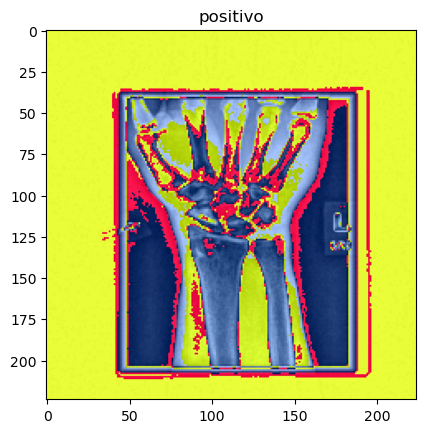

In [282]:
# Visualizamos la 0primera imagen del primer batch
# del conjunto de entrenamiento.
# Cada vez que se vuelva a ejecutar pasa al "batch" siguiente
train_imgs, train_labels = next(iter(train_dataloader))

print(f"Batch shape (images): {train_imgs.size()}")
print(f"Batch shape (labels): {train_labels.size()}")

img = train_imgs[0]
label = train_labels[0]

plt.imshow(F.to_pil_image(img), cmap="gray")
plt.title(training_data.labels_map[label.item()])
plt.show()

In [283]:
# Para continuar con el pipeline hay que recrear los dataloaders
# Pues se han consumido parcialmente al correr antes
# train_imgs, train_labels = next(iter(train_dataloader))

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
print('Número de batches de entrenamiento:\t', len(train_dataloader))

test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
print('Número de batches de test:\t', len(test_dataloader))

Número de batches de entrenamiento:	 153
Número de batches de test:	 11


In [284]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    model.to(device)
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                    dataloader = train_dataloader
                else:
                    model.eval()   # Set model to evaluate mode
                    dataloader = test_dataloader
                    
                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()


                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / len (dataloader.dataset)
                epoch_acc = running_corrects.double() / len (dataloader.dataset)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [285]:
def visualize_model(model, test_dataloader, labels_map, device, num_images=6):
    was_training = model.training
    model.eval()
    model.to(device)
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                prob = probs[j, preds[j]].item()
                ax.set_title(f'predicted: {labels_map[preds[j]]}\nprobability: {prob:.4f}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [286]:
import torch

In [287]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [288]:
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [289]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [290]:
next(iter(range(10)))

0

In [291]:
a=range(10)

In [292]:
print(next(iter(a)))
print(next(iter(a)))

0
0


In [293]:
next(iter(a))

0

In [294]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/3
----------
train Loss: 8.9764 Acc: 0.0000
test Loss: 9.0568 Acc: 0.0000

Epoch 1/3
----------
train Loss: 8.9711 Acc: 0.0000
test Loss: 9.0581 Acc: 0.0000

Epoch 2/3
----------
train Loss: 8.9727 Acc: 0.0000
test Loss: 9.0742 Acc: 0.0000

Epoch 3/3
----------
train Loss: 8.9769 Acc: 0.0001
test Loss: 9.0744 Acc: 0.0000

Training complete in 3m 59s
Best val Acc: 0.000000


In [297]:
visualize_model(model_ft, test_dataloader, label, device, num_images=6)

NameError: name 'dataloader' is not defined

<Figure size 640x480 with 0 Axes>